In [1]:
import os
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## Bayesian General Linear Models

Bayes Theorem and Bayesian inference is used to determine posterior probability distributions. 

Here, Bayesian Inference is applied to a General Linear Model (GLM) for regression. 

### The Model
The objective is to *develop a model to predict student grades* given several input factors for student demographics. The publicly avaliable [UCI dataset](https://archive.ics.uci.edu/ml/datasets/student+performance#) contains grades and factors for 649 students taking a Portugese language course. 

In [2]:
os.listdir('./data')
raw = pd.read_csv('./data/student-por.csv',sep=';')

**Dependent variable or "Target"**
- "G3" is the students final grade for portugese (numeric: from 0 to 20, output target)

***Independent variables or "Features"***

A subset of numeric and categorical features is used to build the initial model:
- "age" student age from 15 to 22
- "internet"  student has internet access at home (binary: yes or no)
- "failures" is the number of past class failures (cat: n if 1<=n<3, else 4) 
- "higher" wants to take higher education (binary: yes or no) 
- "Medu" mother's education (cat: 0 - none, 1 - primary education (4th grade), 2 5th to 9th grade, 3 secondary education or 4 higher education)
-  ""Fedu father's education (cat: 0 - none, 1 - primary education (4th grade), 2 5th to 9th grade, 3 secondary education or 4 higher education)
-  "studytime" weekly study time (cat: 1 - <2 hours, 2 - 2 to 5 hours, 3 - 5 to 10 hours, or 4 - >10 hours)
- "absences" number of school absences (numeric: from 0 to 93) 

In [3]:
# prep Xy data
df = raw.loc[~raw['G3'].isin([0])].copy()
print(df.shape)

# prep features
categoricals = ['internet','failures','higher','Medu','Fedu','studytime']
reals = ['age','absences',]
features = categoricals+reals
target = ['G3']
df = df[features+target].copy()
df[:1]

(634, 33)


,internet,failures,higher,Medu,Fedu,studytime,age,absences,G3
0,no,0,yes,4,4,2,18,4,11


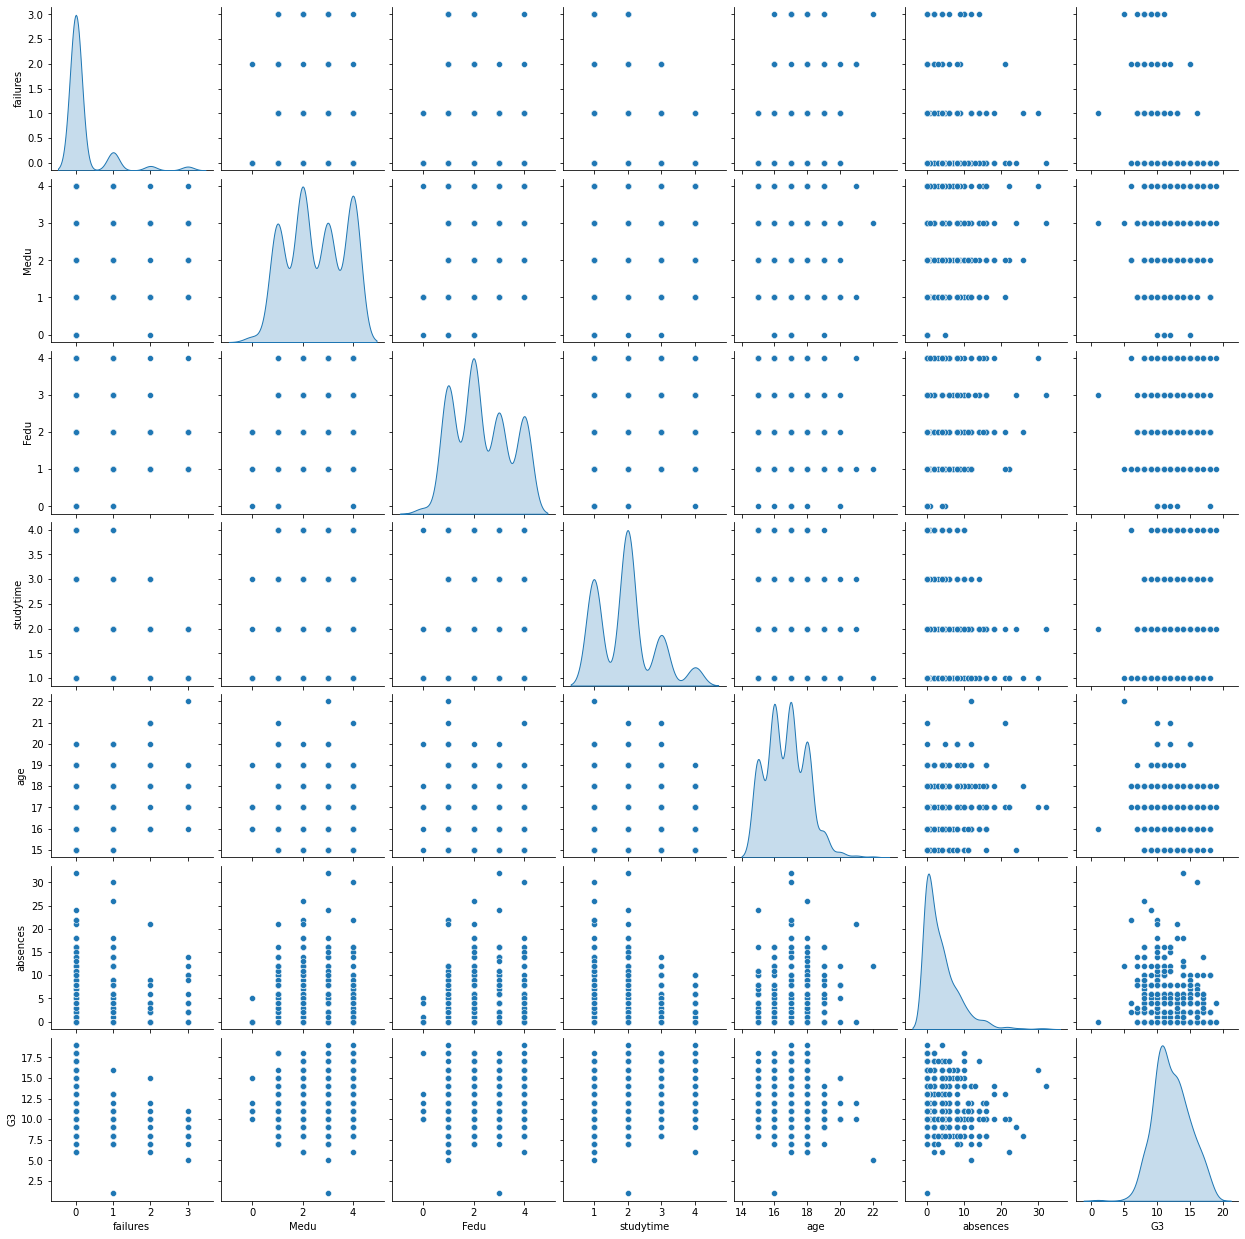

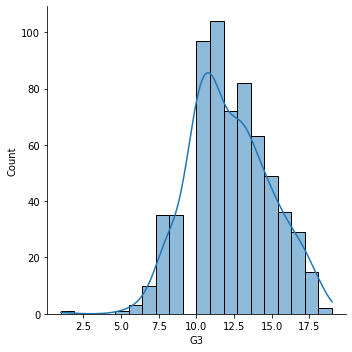

In [4]:
sns.pairplot(data=df,diag_kind='kde')
sns.displot(data=df,x='G3',kde=True);

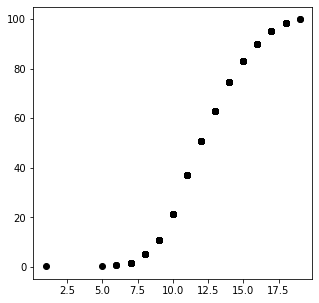

In [5]:
# grade percentiles
# https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.percentileofscore.html
from scipy import stats
df['grade_percentile'] = df['G3'].apply(lambda x: stats.percentileofscore(df['G3'],x))
plt.figure(figsize=(5,5))
plt.scatter(df['G3'],df['grade_percentile'],c='k');

### GLM 

In [6]:
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.graphics.api import abline_plot

Quick recap on OLS or Gaussian GLM.
- Guassian GLm predicts mean value Y (Ymu) given constant scale.

                 Generalized Linear Model Regression Results                  
Dep. Variable:                      y   No. Observations:                  200
Model:                            GLM   Df Residuals:                      198
Model Family:                Gaussian   Df Model:                            1
Link Function:               identity   Scale:                         0.92224
Method:                          IRLS   Log-Likelihood:                -274.69
Date:                Sun, 07 Mar 2021   Deviance:                       182.60
Time:                        14:29:27   Pearson chi2:                     183.
No. Iterations:                     3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -1.1681      0.238     -4.909      0.0

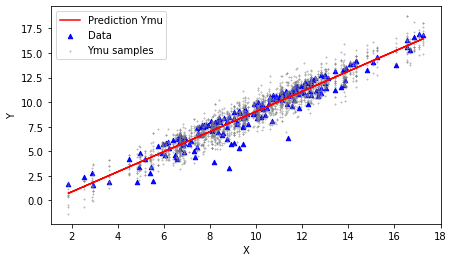

In [7]:
# recap on gaussian model
fig,axs = plt.subplots(1,1,figsize=(7,4))

# dummy data
n = 200
Xy = pd.DataFrame({'X':np.random.normal(loc=10,scale=3,size=n)})
Xy['y'] = Xy.X - np.random.gamma(shape=1,scale=1,size=n)

axs.scatter(Xy.X,Xy.y,c='blue',s=20,marker='^',label='Data')

# fit model
Xym = smf.glm(formula='y~X',data=Xy).fit()
print(Xym.summary())

# prediction : plot mean
Xy['P'] = Xym.predict()
axs.plot(Xy.X,Xy.P,c='red',label='Prediction Ymu')

# predictions : plot 10 samples of model mean with standard deviation
for r in range(10):
    a = np.random.normal(loc=Xy.P,scale=Xym.scale)
    axs.scatter(Xy.X.values,a,marker='x',c='grey',s=1,alpha=0.5)
axs.scatter(Xy.X.values,a,marker='x',c='grey',s=1,alpha=0.5,label='Ymu samples')
axs.set_xlabel('X')
axs.set_ylabel('Y')
    
axs.legend();

Other than age, most features in this dataset have been cut into categories. I could convert the values into objects so that our modelling packages identify and treat variables appropriately. Alternatively in statsmodels formula we can directly specify the categorical variables by "C(categorical_feature)".

In [8]:
# model grade data
formula = [f"{f}" if f not in categoricals else f"C({f})" for f in features]
formula = f'{target[0]} ~ ' + ' + '.join(formula)
glm_ = smf.glm(formula=formula,
              data=df,
              family=sm.families.Gaussian())
glm = glm_.fit()
glm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                     G3   No. Observations:                  634
Model:                            GLM   Df Residuals:                      615
Model Family:                Gaussian   Df Model:                           18
Link Function:               identity   Scale:                          5.0961
Method:                          IRLS   Log-Likelihood:                -1406.2
Date:                Sun, 07 Mar 2021   Deviance:                       3134.1
Time:                        14:29:28   Pearson chi2:                 3.13e+03
No. Iterations:                     3                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept              4.9220      1.890      2.604      0.009       1.217       8.627
C(internet)[T.yes]     0.3737      0.226      1.657      0.098      -0.068       0.816
C(failures)[T.1]      -2.3646      0.323     -7.327      0.000      -2.997      -1.732
C(failures)[T.2]      -2.7874      0.622     -4.481      0.000      -4.007      -1.568
C(failures)[T.3]      -3.0598      0.657     -4.655      0.000      -4.348      -1.771
C(higher)[T.yes]       1.7469      0.330      5.293      0.000       1.100       2.394
C(Medu)[T.1]          -0.1246      0.959     -0.130      0.897      -2.004       1.755
C(Medu)[T.2]           0.1676      0.962      0.174      0.862      -1.717       2.053
C(Medu)[T.3]           0.2000      0.973      0.206      0.837      -1.706       2.106
C(Medu)[T.4]           1.0028      0.981      1.022      0.307      -0.920       2.926
C(Fedu)[T.1]          -0.4706      0.891     -0.528      0.597      -2.217       1.276
C(Fedu)[T.2]          -0.1023      0.898     -0.114      0.909      -1.863       1.659
C(Fedu)[T.3]          -0.4071      0.914     -0.445      0.656      -2.199       1.385
C(Fedu)[T.4]          -0.1982      0.925     -0.214      0.830      -2.011       1.615
C(studytime)[T.2]      0.5495      0.214      2.573      0.010       0.131       0.968
C(studytime)[T.3]      1.0308      0.290      3.552      0.000       0.462       1.600
C(studytime)[T.4]      1.0475      0.421      2.488      0.013       0.222       1.873
age                    0.3272      0.081      4.026      0.000       0.168       0.486
absences              -0.0610      0.020     -3.007      0.003      -0.101      -0.021
======================================================================================
"""

In [9]:
from sklearn import metrics

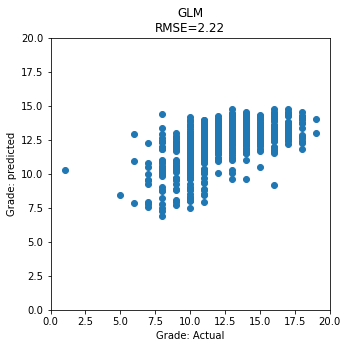

In [10]:
fig,axs = plt.subplots(1,1,figsize=(5,5))

yhat = glm.predict(df)
rmse = np.sqrt(np.mean((yhat - df[target].values.reshape(-1,))**2))
rmse = metrics.mean_squared_error(df[target],yhat,squared=False)

axs.scatter(df[target],yhat)
axs.set_title(f'GLM\nRMSE={rmse:.2f}')
axs.set_xlabel('Grade: Actual')
axs.set_ylabel('Grade: predicted')
axs.set_xlim(0,20)
axs.set_ylim(0,20);

## PyMC3 GLM

Now lets re-build our GLM model using PyMC3. This [post](https://twiecki.io/blog/2013/08/12/bayesian-glms-1/) is the official guide.

In [25]:
import pymc3 as pm
import arviz as avz

In [12]:
# note we can re-use our formula 
formula

'G3 ~ C(internet) + C(failures) + C(higher) + C(Medu) + C(Fedu) + C(studytime) + age + absences'

In [14]:
bglm = pm.Model()
with bglm:
    # Normally distributed priors
    family = pm.glm.families.Normal()
    
    # create the model 
    pm.GLM.from_formula(formula,data=df,family=family)
    
    # sample
    trace = pm.sample(1000,return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sd, absences, age, C(studytime)[T.4], C(studytime)[T.3], C(studytime)[T.2], C(Fedu)[T.4], C(Fedu)[T.3], C(Fedu)[T.2], C(Fedu)[T.1], C(Medu)[T.4], C(Medu)[T.3], C(Medu)[T.2], C(Medu)[T.1], C(higher)[T.yes], C(failures)[T.3], C(failures)[T.2], C(failures)[T.1], C(internet)[T.yes], Intercept]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 47 seconds.
The acceptance probability does not match the target. It is 0.8851377942368025, but should be close to 0.8. Try to increase the number of tuning steps.


Once the model has run we can examine the model posterior distribution samples. This is akin to viewing the ```model.summary()``` of a classic linear model. Here the mean is the estimate of the feature distribution. In our case the model intercept mean is around 4.9, meaning a student is expected to attain at least a grade of 4.9 irrespective of what we know about them. 

The 3-97% highest posterior density "hpd" range indicates the credible interval for the true value of our parameter. As for classical models if this range crosses 0, from negative effect to positive effect, then perhaps the data signal is too weak to draw conclusions for this variable. This is the case for Internet usage - darnit Covid19. 

[**NOTE** in January 2021 Pymc3 updated many plotting feature to arviz](https://github.com/pymc-devs/pymc3/blob/master/RELEASE-NOTES.md#pymc3-3110-21-january-2021)

```
# where
pm.summary()

# becomes
arviz.summary()
```

the output of p.sample() is also now cross platform [InferenceData](https://arviz-devs.github.io/arviz/schema/schema.html)

```
t = trace['posterior']
t.data_vars.variables['Intercept'].mean()
```

In [29]:
summary = avz.summary(trace)
summary[:5]

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,4.926,1.897,1.494,8.574,0.047,0.033,1622.0,2618.0,1.0
C(internet)[T.yes],0.374,0.232,-0.074,0.807,0.003,0.003,6395.0,2569.0,1.0
C(failures)[T.1],-2.366,0.324,-2.981,-1.751,0.005,0.003,4742.0,2990.0,1.0
C(failures)[T.2],-2.790,0.632,-3.965,-1.605,0.009,0.006,5426.0,3052.0,1.0
C(failures)[T.3],-3.052,0.663,-4.231,-1.792,0.009,0.007,5553.0,2539.0,1.0


The posterior distributions can also be viewed via traceplots. 

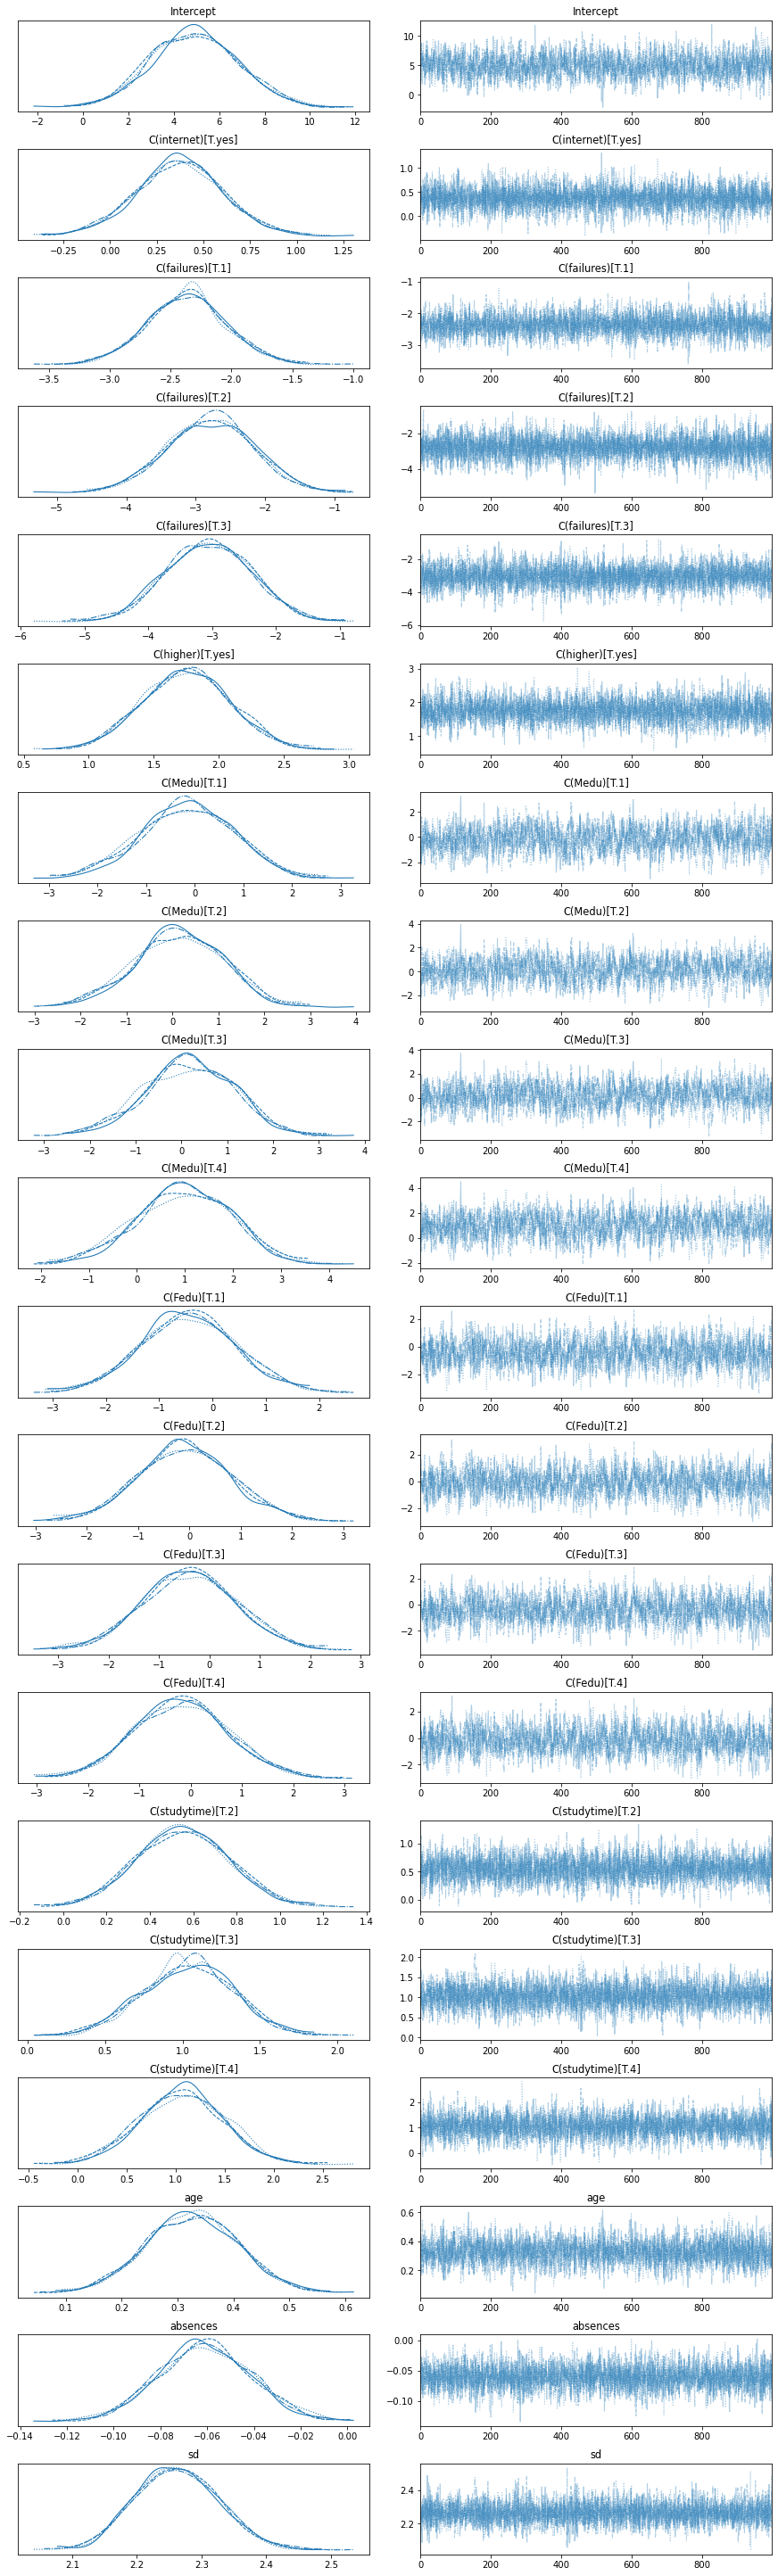

In [31]:
import warnings
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    avz.plot_trace(trace)
    
# alternatively via the posterior plot function
# pm.plot_posterior(trace);

## Interpret Variable effect on Predicted Grade

In [32]:
# Examines the effect of changing a single variable
# Takes in the name of the variable, the trace, and the data
def model_effect(query_var, trace, X):
    
    # Variables that do not change
    steady_vars = list(X.columns)
    steady_vars.remove(query_var)
    
    # Linear Model that estimates a grade based on the value of the query variable 
    # and one sample from the trace
    def lm(value, sample):
        
        # Prediction is the estimate given a value of the query variable
        prediction = sample['Intercept'] + sample[query_var] * value
        
        # Each non-query variable is assumed to be at the median value
        for var in steady_vars:
            
            # Multiply the weight by the median value of the variable
            prediction += sample[var] * X[var].median()
        return prediction
    
    
    # Find the minimum and maximum values for the range of the query var
    var_min = X[query_var].min()
    var_max = X[query_var].max()
    
    # Plot the estimated grade versus the range of query variable
    pm.plot_posterior_predictive_glm(trace, eval=np.linspace(var_min, var_max, 100), 
                                     lm=lm, samples=100, color='blue', 
                                     alpha = 0.4, lw = 2)
    
    # Plot formatting
    plt.xlabel('%s' % query_var, size = 16)
    plt.ylabel('Grade', size = 16)
    plt.title("Posterior of Grade vs %s" % query_var, size = 18)
    plt.show()

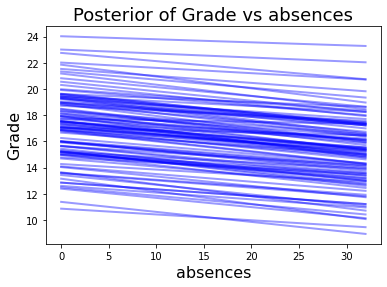

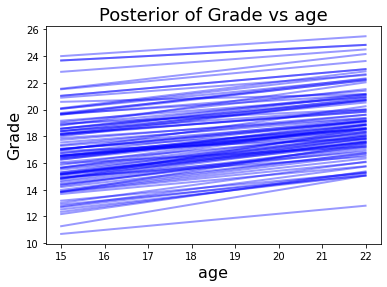

In [33]:
X = pd.DataFrame(data=glm_.data.exog,columns=glm_.data.param_names) # dmatrix
model_effect('absences',trace,X)
model_effect('age',trace,X)

## Posterior Predictive Checks 
[Posterior predictive checks (PPCs)](https://docs.pymc.io/notebooks/posterior_predictive.html) and [sample_posterior_predictive()](https://docs.pymc.io/api/inference.html#pymc3.sampling.sample_posterior_predictive) provide sampling over the fitted trace of model parameters. As per the PyMC3 docs prior predictive checks are also a crucial part of the Bayesian modeling workflow. Basically, they have two main benefits:

- *They allow you to check whether you are indeed incorporating scientific knowledge into your model – in short, they help you check how credible your assumptions before seeing the data are.*
- *They can help sampling considerably, especially for generalized linear models, where the outcome space and the parameter space diverge because of the link function.*


Below, sampling is used to sample the Y outcome of our model *n* times (left). The KDE plot the of observed true Y is shown for comparison. Similar to the above trace plots, PPC can also provide specific sampling of model parameters such as Age (right).

/home/ben/miniconda3/envs/ml/lib/python3.8/site-packages/pymc3/sampling.py:1688: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  warnings.warn(


/home/ben/miniconda3/envs/ml/lib/python3.8/site-packages/pymc3/sampling.py:1688: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  warnings.warn(


<AxesSubplot:title={'center':'PPC a\nsamples=200'}, ylabel='Density'>

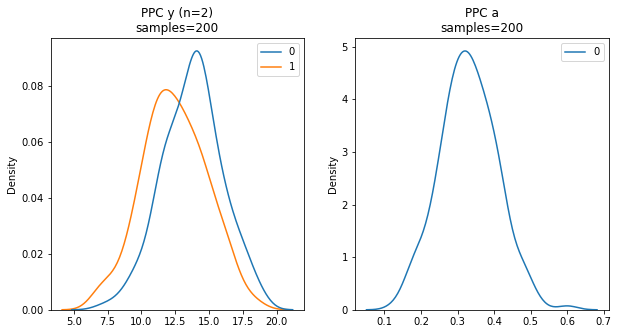

In [70]:
# this samples the posterior distribution predictions on the train set
fig,axs = plt.subplots(1,2,figsize=(10,5))

n = 2
samples = 200
var = 'y'
axs[0].set_title(f"PPC {var} (n={n})\nsamples={samples}")
with bglm:
    p = pm.sample_posterior_predictive(trace,
                                       samples=samples,
                                       model=bglm,
                                       var_names=[var])
sns.kdeplot(data=pd.DataFrame(p[var][:,:n]),ax=axs[0])

# this samples the posterior coefficient distributions 
# for either Y or a specific var_name
var = 'age'
axs[1].set_title(f"PPC {var[0]}\nsamples={samples}")
with bglm:
    p = pm.sample_posterior_predictive(trace,
                                       samples=samples,
                                       model=bglm,
                                       var_names=[var])
sns.kdeplot(data=pd.DataFrame(p[var]),ax=axs[1])

## Predictions on Out-Of-Sample (OOS) data

### method 1: the mean model
We can use the MCMC trace to obtain a sample mean for the model coefficients and construct a typical GLM formula. Remember we used statsmodels-patsy formulation to encode our categorical variables, well we can again use patsy to construct a helper.

In [135]:
# mean model coefficients
mean_model = summary[['mean']].T.reset_index(drop=True)

# create a  design matrix of exog data values
# same as for GLM's
X = pd.DataFrame(data=glm_.data.exog,columns=glm_.data.param_names)

# add columns for the standard deviations output from the bayesian fit
for x in mean_model.columns:
    if x not in X.columns:
        X[x] = 1
        
# multiply and work out mu predictions
coefs = X * mean_model.values
pred_mu = coefs.iloc[:,:-1].sum(axis=1)[:]
pred_sd = coefs['sd']
print('Predictions:')
n = 5
for m,s in zip(pred_mu[:n],pred_sd[:n]): print(f"\tMu:{m:.2f} Sd:{s:.2f}")

Predictions:
	Mu:13.66 Sd:2.26
	Mu:12.43 Sd:2.26
	Mu:11.53 Sd:2.26
	Mu:13.88 Sd:2.26
	Mu:12.24 Sd:2.26


### method 2: >> See next notebook 



### Plot comparing predictions
 - observed data
 - GLM on train or test
 - PPC on train
 - bayes method 1: reconstruct GLM formula and sample test

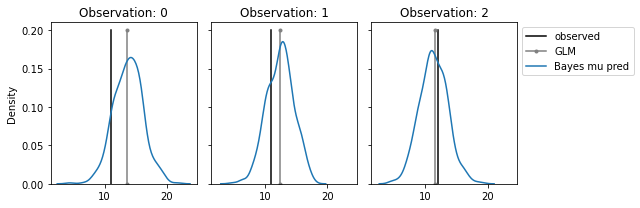

In [137]:
results = list()
N = 3
fig,axs=plt.subplots(1,N,sharex=True,sharey=True,figsize=(N*3,3))

for i in range(500):
    # random sample of predicted mu,scale
    results.append(np.random.normal(loc=pred_mu,scale=pred_sd)[:N])
results = np.array(results).T

for n in range(N):
    # plot observed Y
    axs[n].plot([df[target].iloc[n],df[target].iloc[n]],
             [0,0.2],'k-',label=f'observed')
    
    # plot GLM prediction of Y (only works here because Xtrain=Xtest)
    axs[n].plot([glm.predict(df)[n],glm.predict(df)[n]],
                [0,0.2],'.-',color='grey',label=f'GLM')
    
    # plot mu prediction kde for Y
    sns.kdeplot(results[n],label=f'Bayes mu pred',ax=axs[n]) 
    

    
    # plot ppc prediction of Y (only works here because Xtrain=Xtest)
#     axs[n].plot([ppc['y'][:,n].mean(axis=0),ppc['y'][:,n].mean(axis=0)],
#                 [0,0.2],'x-',label=f'Bayes ppc')
    axs[n].set_title(f"Observation: {n}")
axs[n].legend(bbox_to_anchor=(1,1,))
plt.tight_layout();

## references
- [Getting started with GLM in PyMC3](https://docs.pymc.io/notebooks/getting_started.html?highlight=glm)
- [All GLM examples in PyMC3](https://docs.pymc.io/notebooks/GLM.html)
- [Robust GLM's in PyMC3](https://docs.pymc.io/notebooks/GLM-robust.html)
- [PyMC3 OLS Regression](https://docs.pymc.io/notebooks/GLM-linear.html)
- [PyMC3 Logistic Regression](https://docs.pymc.io/notebooks/GLM-logistic.html)



- https://towardsdatascience.com/bayesian-linear-regression-in-python-using-machine-learning-to-predict-student-grades-part-2-b72059a8ac7e
 - https://github.com/WillKoehrsen/Data-Analysis/blob/master/bayesian_lr/Bayesian%20Linear%20Regression%20Project.ipynb
- https://www.google.com/search?client=firefox-b-d&q=plot_posterior_predictive
- https://stackoverflow.com/questions/37312817/pymc3-bayesian-linear-regression-prediction-with-sklearn-datasets
- https://stackoverflow.com/questions/33249122/generating-predictions-from-inferred-parameters-in-pymc3
- https://docs.pymc.io/notebooks/posterior_predictive.html
- https://docs.pymc.io/Advanced_usage_of_Theano_in_PyMC3.html
